In [15]:
#CS 513: Knowledge Discovery and Data 
#Group Members: Danica Lacuesta, Joelle An, and Raj Rana 
#Author: Danica Lacuesta
#20014543
#"I pledge my honor that I have abided by the Stevens Honor System"
#Purpose: This project analyzes digital activity patterns to classify user stress levels and identify the behavioral features that most strongly impact predictive accuracy.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/Digital_Stress_Classifier_preprocess.csv")

# Create X and y after clipping
X = df.drop("Stress_Binary", axis=1)
y = df["Stress_Binary"]

# Scale features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Accuracy: 0.8322147651006712

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.69      0.66        35
           1       0.90      0.88      0.89       114

    accuracy                           0.83       149
   macro avg       0.77      0.78      0.77       149
weighted avg       0.84      0.83      0.83       149



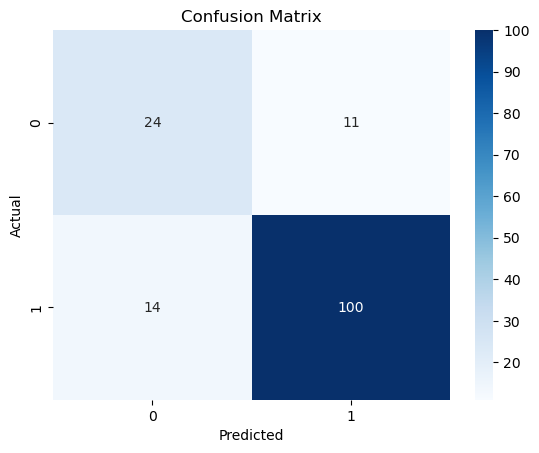

In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nb = GaussianNB()
nb.fit(X_train, y_train)

pred = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


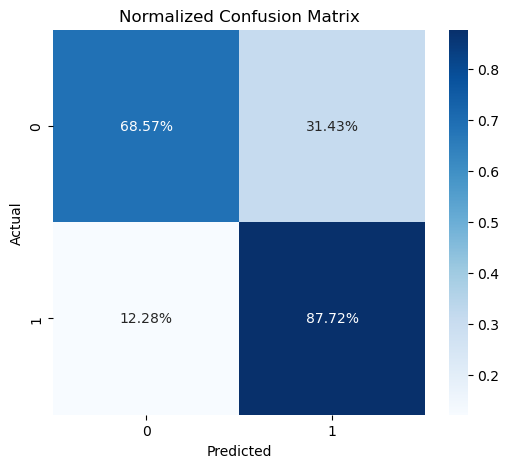

In [41]:
import numpy as np

cm = confusion_matrix(y_test, pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap="Blues")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

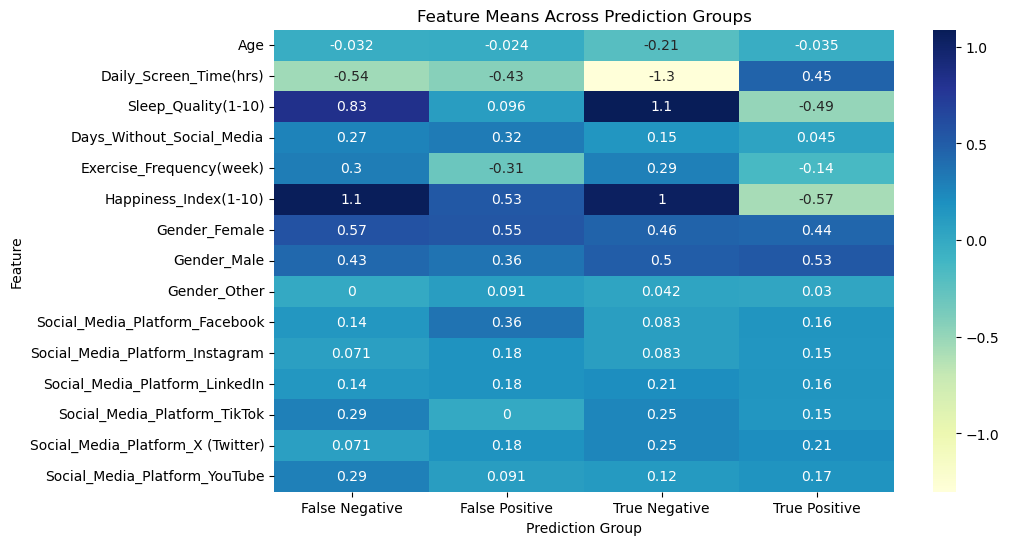

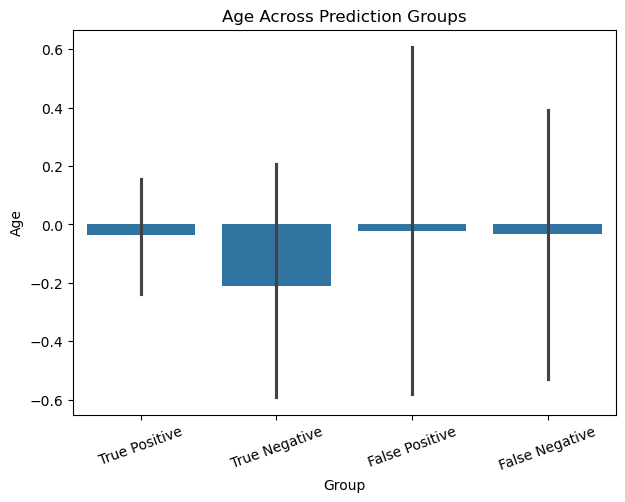

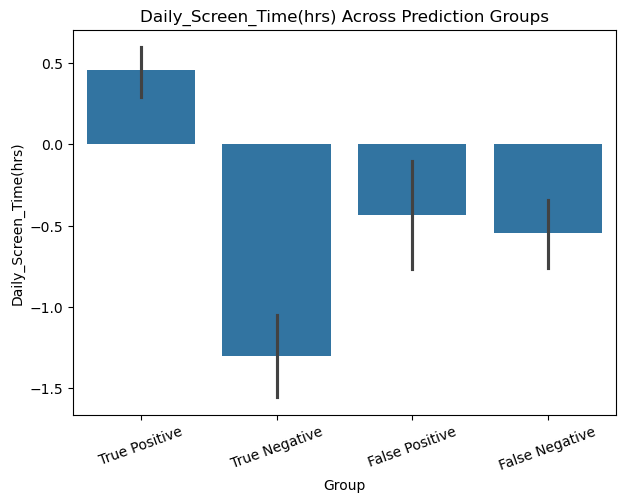

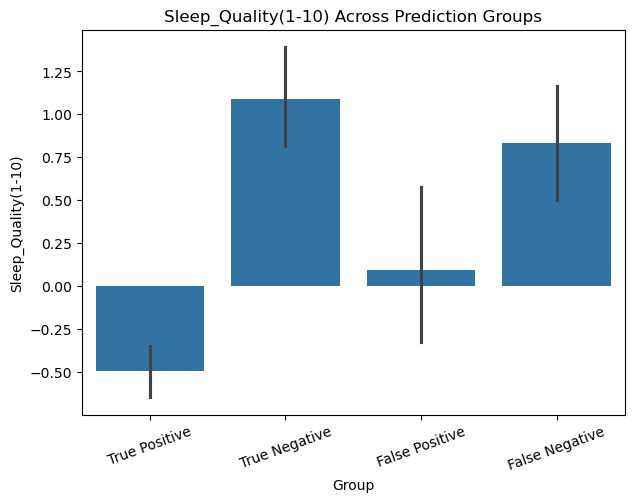

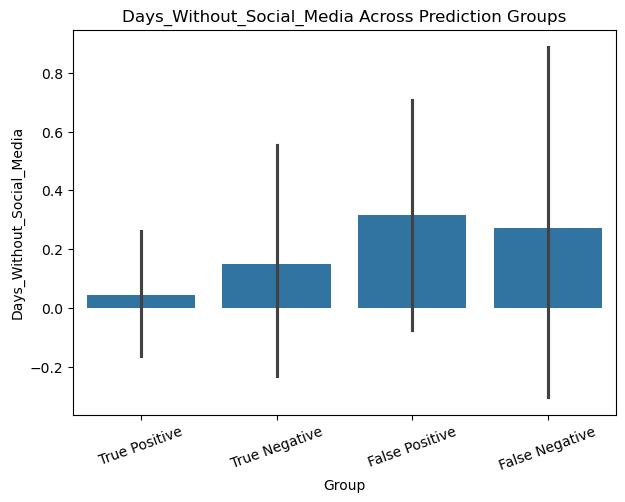

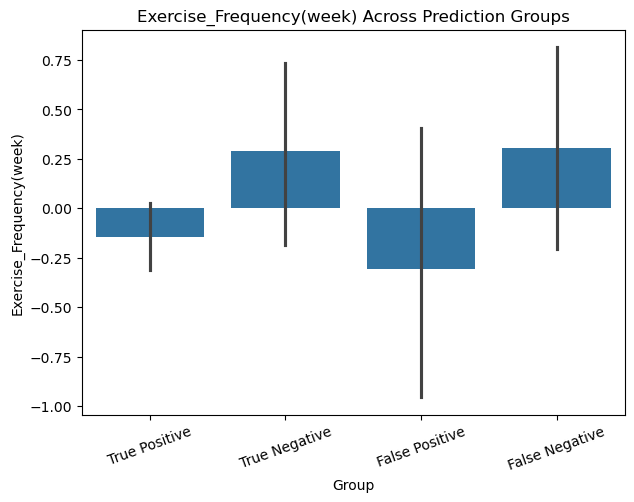

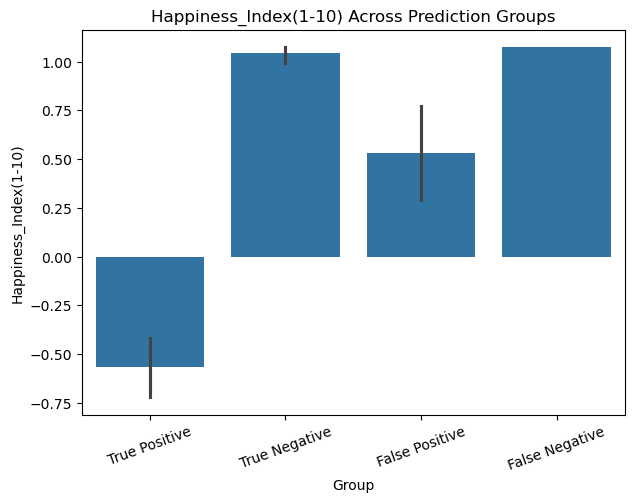

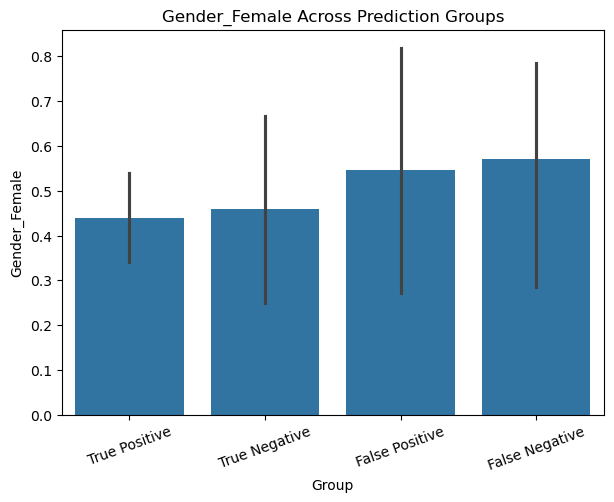

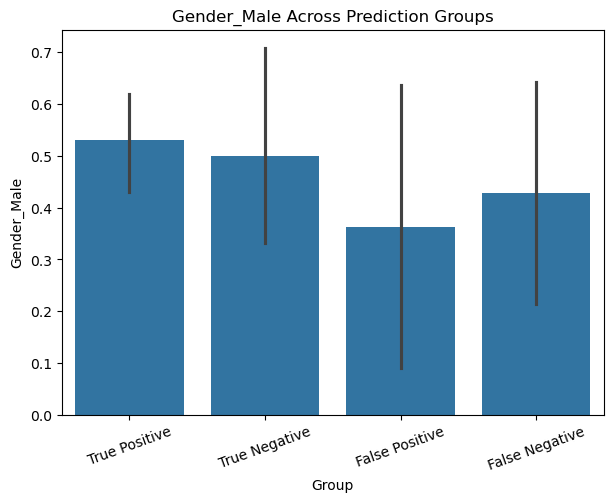

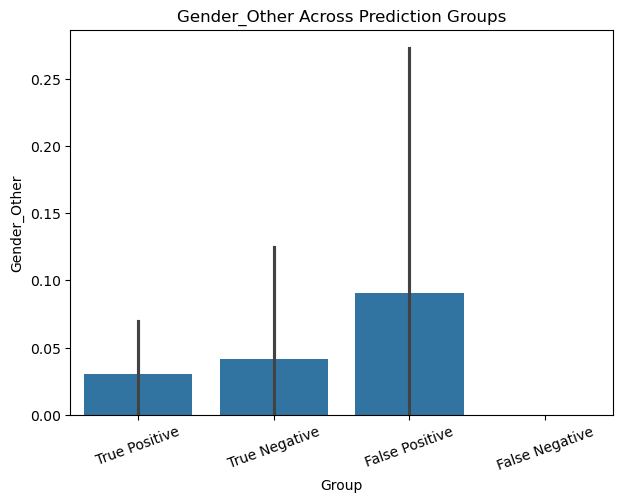

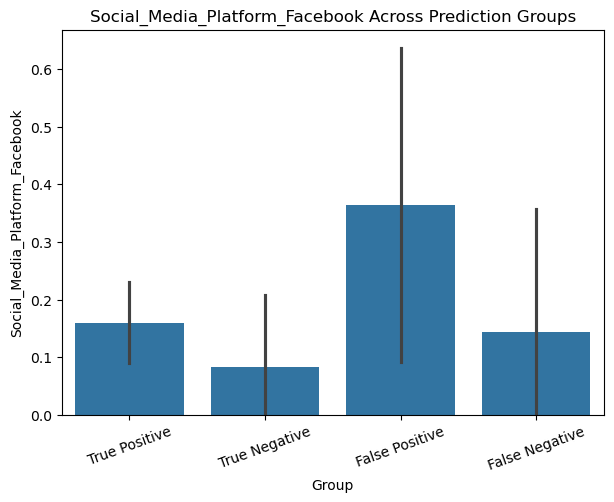

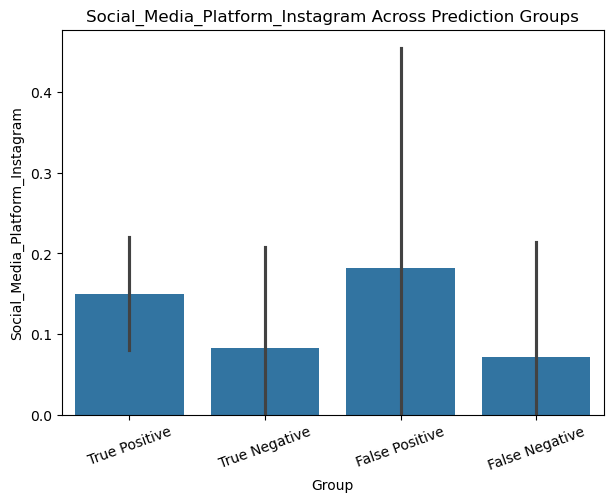

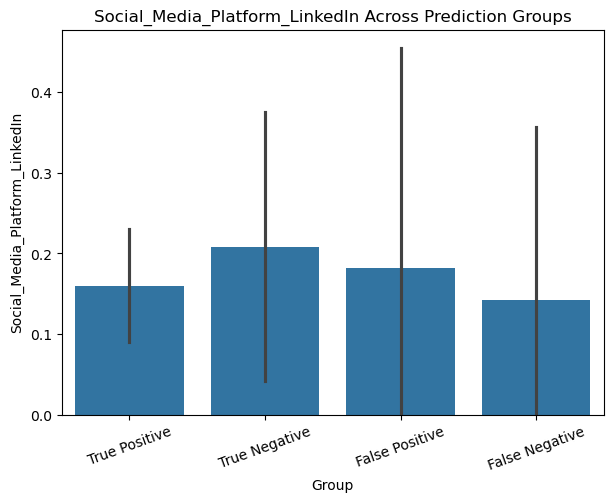

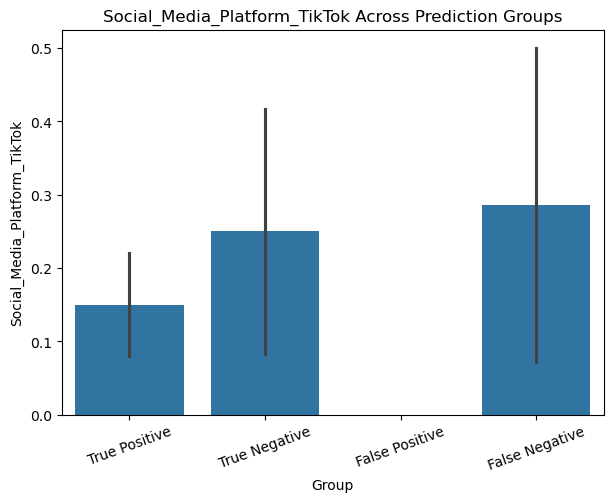

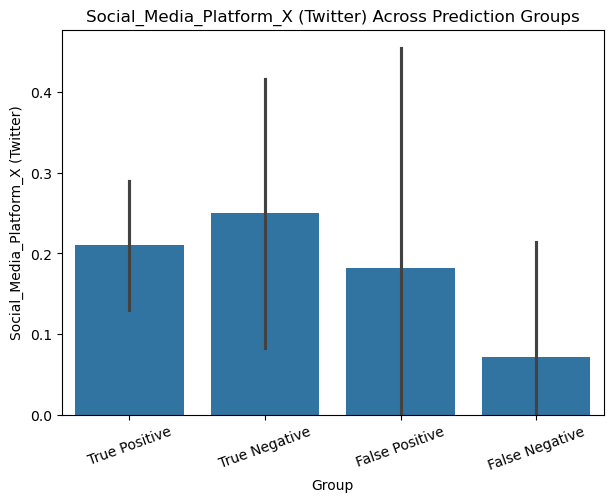

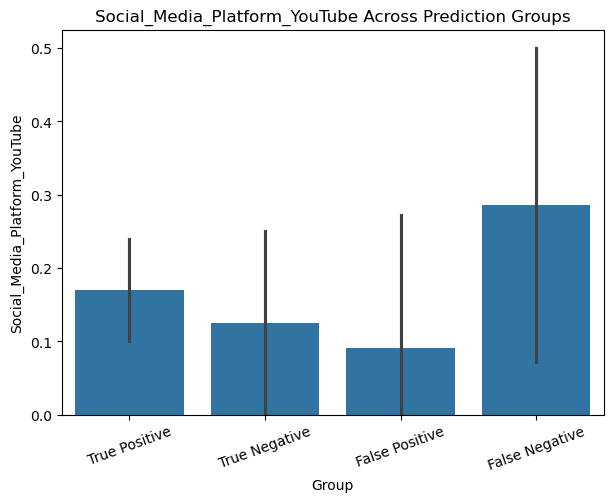

In [42]:
# Convert X_test (scaled NumPy array) back to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)

results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": pred
})
results = pd.concat([results, X_test_df], axis=1)

def get_group(row):
    if row["Actual"] == 1 and row["Predicted"] == 1:
        return "True Positive"
    if row["Actual"] == 0 and row["Predicted"] == 0:
        return "True Negative"
    if row["Actual"] == 1 and row["Predicted"] == 0:
        return "False Negative"
    if row["Actual"] == 0 and row["Predicted"] == 1:
        return "False Positive"

results["Group"] = results.apply(get_group, axis=1)

features = [
    "Age",
    "Daily_Screen_Time(hrs)",
    "Sleep_Quality(1-10)",
    "Days_Without_Social_Media",
    "Exercise_Frequency(week)",
    "Happiness_Index(1-10)",
    "Gender_Female",
    "Gender_Male",
    "Gender_Other",
    "Social_Media_Platform_Facebook",
    "Social_Media_Platform_Instagram",
    "Social_Media_Platform_LinkedIn",
    "Social_Media_Platform_TikTok",
    "Social_Media_Platform_X (Twitter)",
    "Social_Media_Platform_YouTube"
]



feature_means = results.groupby("Group")[features].mean().T

plt.figure(figsize=(10, 6))
sns.heatmap(feature_means, annot=True, cmap="YlGnBu")
plt.title("Feature Means Across Prediction Groups")
plt.xlabel("Prediction Group")
plt.ylabel("Feature")
plt.show()

order = ["True Positive", "True Negative", "False Positive", "False Negative"]

for feature in features:
    plt.figure(figsize=(7, 5))
    sns.barplot(
        x="Group",
        y=feature,
        data=results,
        order=order
    )

    plt.title(f"{feature} Across Prediction Groups")
    plt.xticks(rotation=20)
    plt.show()


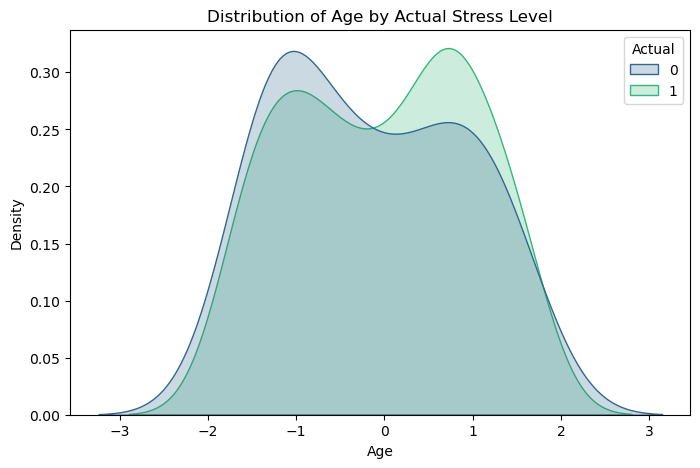

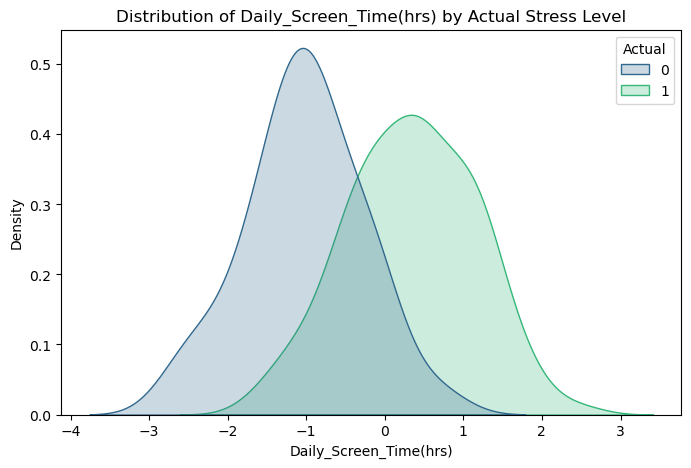

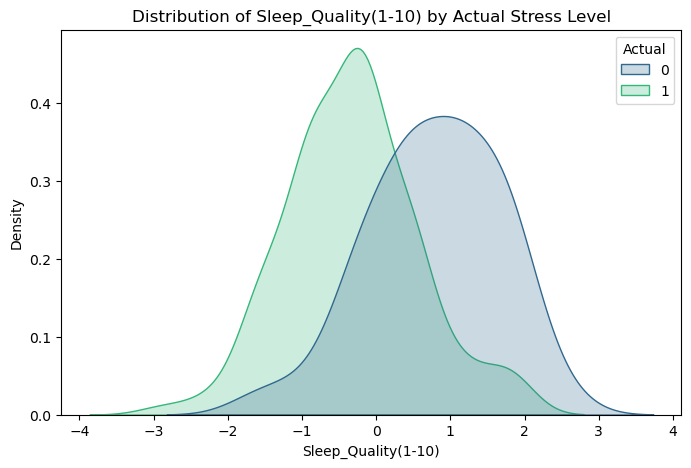

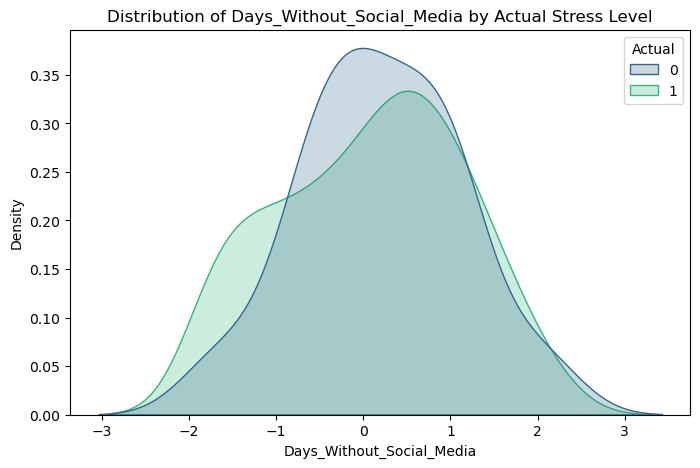

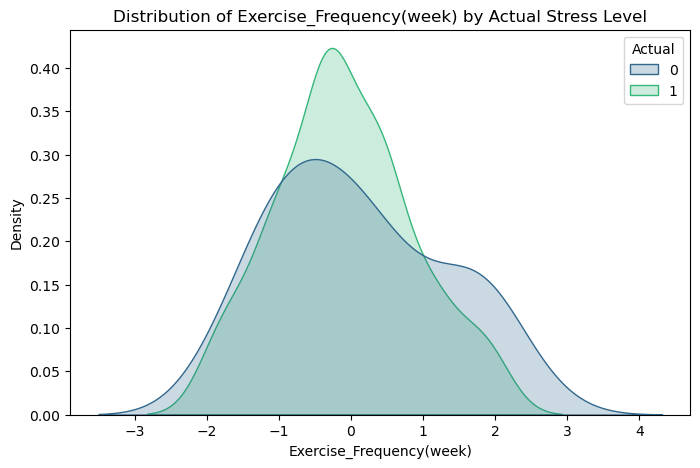

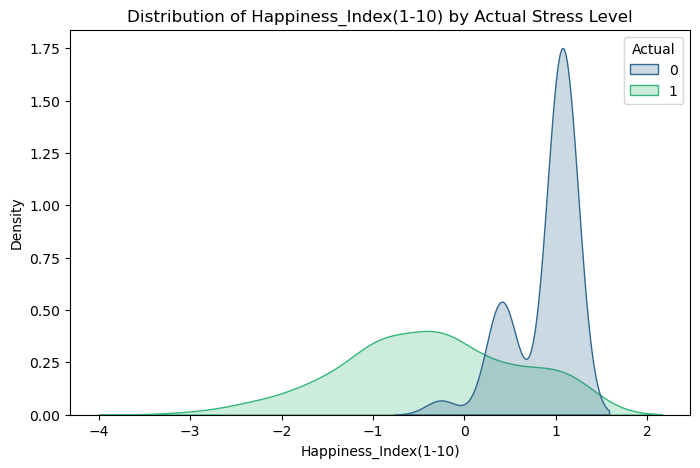

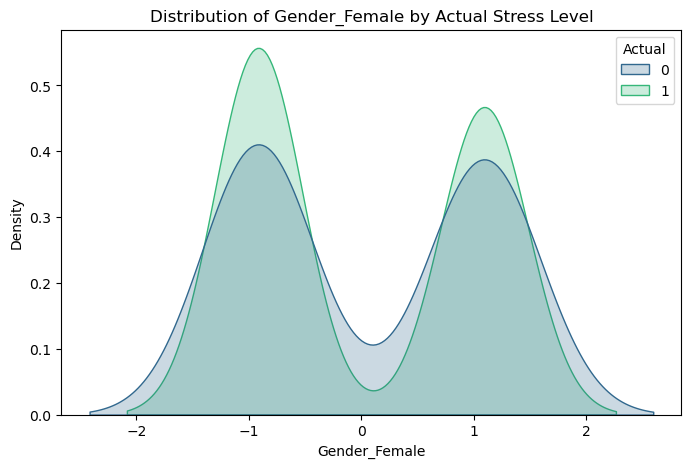

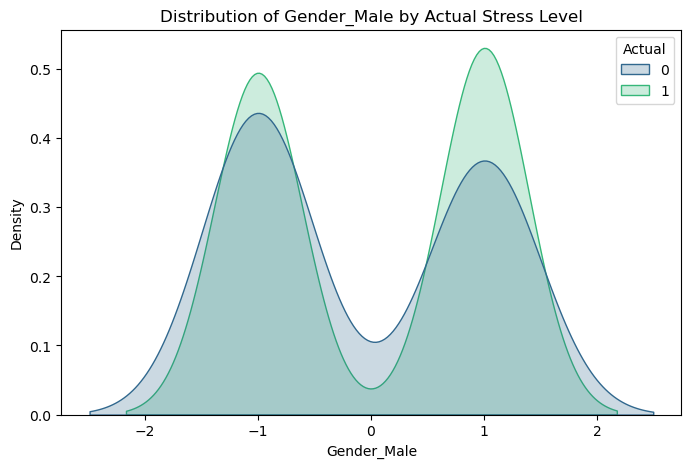

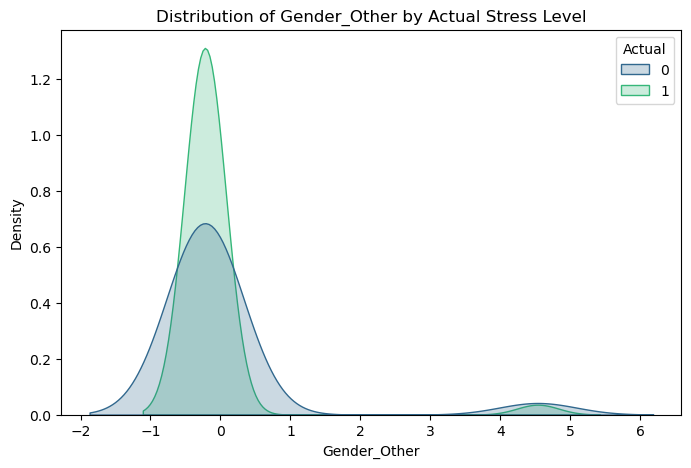

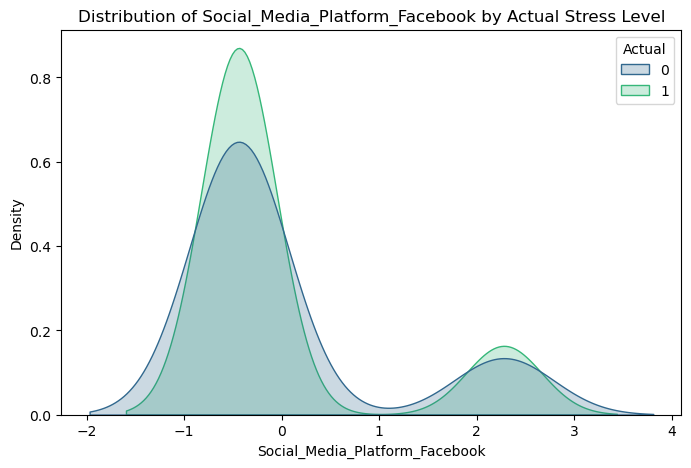

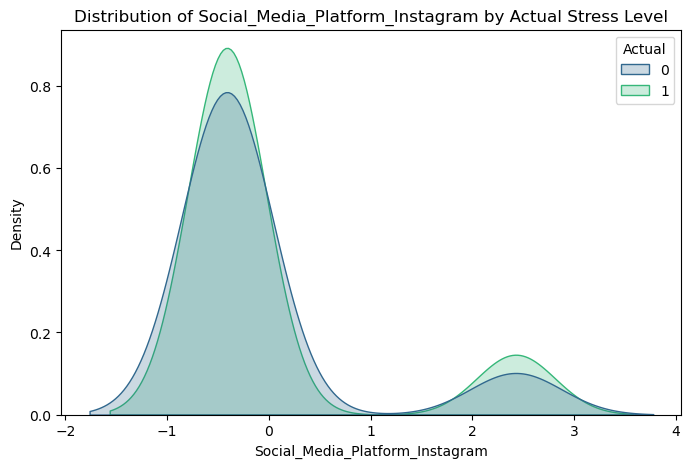

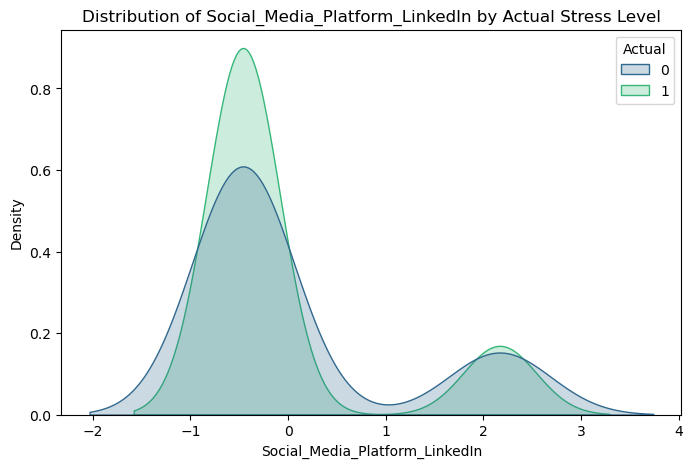

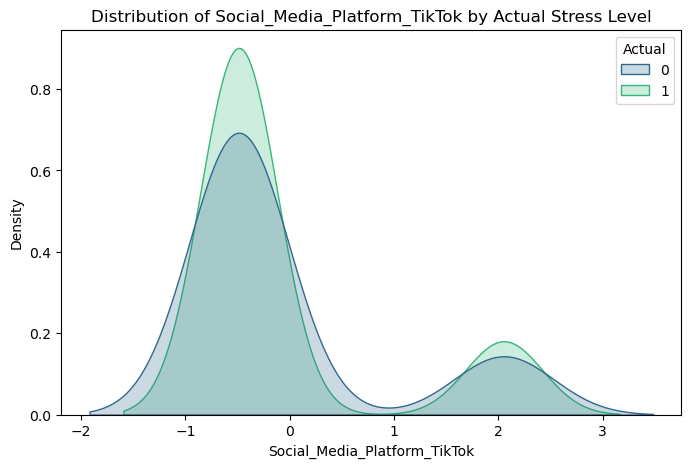

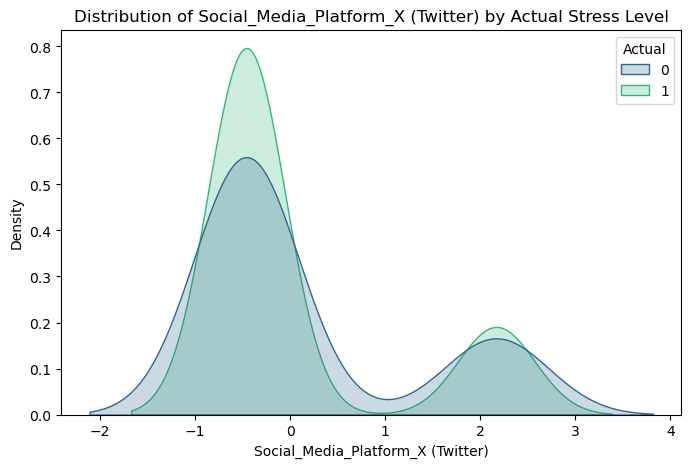

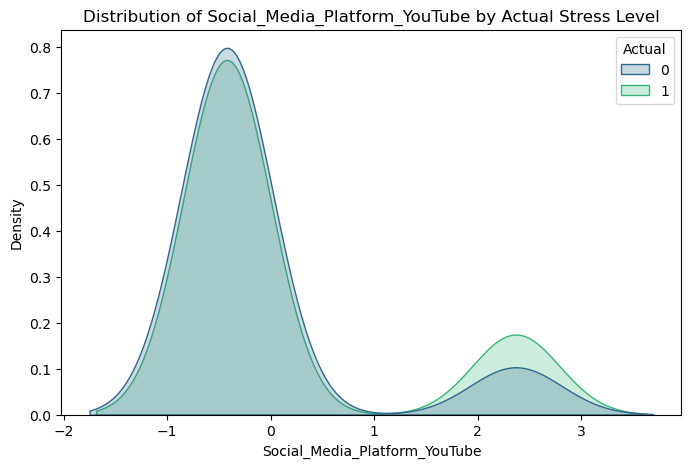

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

for feature in features:
    plt.figure(figsize=(8,5))
    sns.kdeplot(
        data=results, 
        x=feature, 
        hue="Actual", 
        fill=True,
        common_norm=False,
        palette="viridis"
    )
    plt.title(f"Distribution of {feature} by Actual Stress Level")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.show()

In [37]:
misclassified_summary = results[results["Group"].isin(["False Positive", "False Negative"])]

print("Counts:")
print(misclassified_summary["Group"].value_counts())

print("\nSamples:")
display(misclassified_summary[["Group"] + features].head(10))


Counts:
Group
False Negative    14
False Positive    11
Name: count, dtype: int64

Samples:


,Group,Age,Daily_Screen_Time(hrs),Sleep_Quality(1-10),Days_Without_Social_Media,Exercise_Frequency(week),Happiness_Index(1-10),Gender_Female,Gender_Male,Gender_Other,Social_Media_Platform_Facebook,Social_Media_Platform_Instagram,Social_Media_Platform_LinkedIn,Social_Media_Platform_TikTok,Social_Media_Platform_X (Twitter),Social_Media_Platform_YouTube
3,False Negative,-0.700778,-0.306248,-0.203486,-0.073736,-1.019260,1.073037,1.093019,-0.995976,-0.220513,-0.438529,-0.412082,-0.461209,2.054520,-0.461209,-0.422075
6,False Negative,0.405863,-0.483217,1.775519,-0.073736,-1.019260,1.073037,1.093019,-0.995976,-0.220513,-0.438529,-0.412082,-0.461209,-0.486732,-0.461209,2.369247
8,False Positive,0.405863,-1.309075,0.456182,1.539772,1.119892,0.408585,1.093019,-0.995976,-0.220513,2.280351,-0.412082,-0.461209,-0.486732,-0.461209,-0.422075
18,False Negative,-1.103194,-0.188268,1.775519,1.001936,-1.019260,1.073037,-0.914897,1.004040,-0.220513,-0.438529,-0.412082,-0.461209,2.054520,-0.461209,-0.422075
26,False Negative,-0.398967,-0.188268,0.456182,-1.149407,1.832943,1.073037,1.093019,-0.995976,-0.220513,-0.438529,-0.412082,-0.461209,-0.486732,-0.461209,2.369247
34,False Positive,1.009486,-1.132106,1.115850,-0.073736,-1.019260,0.408585,-0.914897,1.004040,-0.220513,2.280351,-0.412082,-0.461209,-0.486732,-0.461209,-0.422075
38,False Positive,-0.097156,-0.601197,1.115850,1.001936,-1.732311,1.073037,-0.914897,-0.995976,4.534889,-0.438529,-0.412082,-0.461209,-0.486732,2.168213,-0.422075
43,False Negative,0.104052,-1.014126,0.456182,2.077607,1.832943,1.073037,-0.914897,1.004040,-0.220513,-0.438529,-0.412082,-0.461209,2.054520,-0.461209,-0.422075
47,False Negative,0.305259,-0.306248,1.115850,0.464100,1.119892,1.073037,1.093019,-0.995976,-0.220513,-0.438529,-0.412082,2.168213,-0.486732,-0.461209,-0.422075
49,False Positive,-1.405005,0.696580,-0.203486,0.464100,-0.306209,0.408585,1.093019,-0.995976,-0.220513,2.280351,-0.412082,-0.461209,-0.486732,-0.461209,-0.422075
